In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

In [2]:
import os
import zipfile
import shutil
import pandas as pd
from pathlib import Path

import requests
from helper_functions import set_seeds
from torchvision.models import resnet18, ResNet18_Weights

In [3]:
from skimage import io,transform
from matplotlib import pyplot as plt
import torch.optim as optim
import numpy as np

In [4]:
from torchvision.io import read_image

In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# Setup path to data folder
data_path = Path("Mnist_Image_Data/")

train_dir = data_path / "Images" / "train"
test_dir = data_path / "Images"/ "test"

In [7]:
# Initializing model with the default (best) available weights
# chose resnet 18 since it is generally simple and faster to train - I tried other models but it took way too long to train the model 
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()
preprocess = weights.transforms()

In [8]:
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
#Freeze the base parameters
# freeze all layers so that the model can be used for MNIST dataset - freezing speeds up the training process and prevents overfitting 
for parameter in model.parameters():
    parameter.requires_grad = False

In [10]:
#need to modify the connected layer so that the model adjusts for the 10 class outputs 
model.fc = nn.Linear(model.fc.in_features, 10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=3, bias=False)

In [11]:

import os
from PIL import Image

In [12]:


#using class from previous MNIST example in info3000 - need to use it to combine the csv file data with the actual picture
# also need to normalize data 
class MNIST():

    def __init__(self, dataset, dir, transform=None):
        self.dataset = dataset
        self.dir = dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        img_name = os.path.join(self.dir, self.dataset.iloc[idx, 0]) 
        img = Image.open(img_name).convert('L')  # Open image in grayscale mode

        label = self.dataset.iloc[idx, 1]

        # Resizing
        img = img.resize((32, 32))

        # Applying the transform (if provided)
        if self.transform:
            img = self.transform(img)

        img = transforms.ToTensor()(img)
        label = torch.tensor(int(label))

        return img, label




In [13]:
dataset_path_train = 'Mnist_Image_Data/train.csv'
dataset_path_test = 'Mnist_Image_Data/test.csv'

train_csv = pd.read_csv(dataset_path_train)
test_csv = pd.read_csv(dataset_path_test)

train_data = MNIST(dataset=train_csv, dir=train_dir)
test_data = MNIST(dataset=test_csv, dir=test_dir)

print(train_data.__len__(),test_data.__len__())  

49000 100


In [14]:
from skimage import io,transform
from skimage.color import rgb2gray
from matplotlib import pyplot as plt

<class 'torch.Tensor'>
Shape of Imagetorch.Size([1, 32, 32]) datatype iamge: <class 'torch.Tensor'> datalabel: <class 'torch.Tensor'>
(32, 32)
torch.Size([])


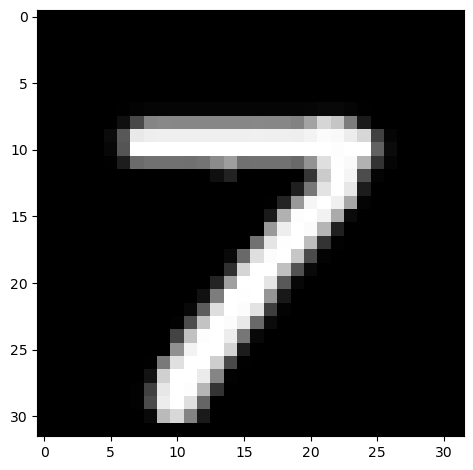

In [15]:
#used this from INFO3000 example using MNIST 

# Get image from dataset
image1,label1 = train_data.__getitem__(1000)
print(type(label1))
print(f"Shape of Image{image1.shape} datatype iamge: {type(image1)} datalabel: {type(label1)}")
image1 = (image1.numpy()).reshape(32,32)

# Check the shape of the image
print(image1.shape)
print(label1.shape)

# Display image
io.imshow(image1)
plt.show()

In [16]:
#dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [18]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_dataloader:
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Testing the model
correct = 0
total = 0
with torch.no_grad():

    for images, labels in test_dataloader:

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy}%")

Accuracy on test set: 86.0%
